In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns

Before I move on to model, I organized data. we will use ["Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Transparency", "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"] columns. Also we will focus on classifying 7 zooplanktons, which are ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"] therefore we assigned "Othres" if a zooplankton is not in the list. However to make good model it's important to reduce false positive, which incorrectly predicts a plankton as belonging to one of the selected classes when it actally belongs to "Others". For now we use base threshold but we can think of increase threshold later. 

In [2]:
# The dataframe is created by merging all CSV files
df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

feature_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Symmetry", 
    "Circularity", "Convexity", "Aspect.Ratio", "Compactness", "Elongation", "Fiber.Curl", 
    "Fiber.Straightness", "Roughness", "Transparency", "Sum.Intensity", "Intensity", 
    "Sigma.Intensity", "Edge.Gradient"
]
target_col = "Class"

selected_classes = ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"]

# Exclude 'TooSmall' class from the dataframe
df = df[df[target_col] != 'TooSmall']

In [3]:
# Why there are so big planktons

# Sort by area and select top 10
top_area = df.sort_values(by='Area..ABD.', ascending=False).iloc[70:80]

# Columns needed for cropping the original image
# cols_to_extract = ['Image.File', 'Class', 'Image.Height', 'Image.Width', 'Image.X', 'Image.Y', 'Source_File']
cols_to_extract = ['Image.File', 'Class', 'Area..ABD.']
top_area_info = top_area[cols_to_extract]

# Show the info
print(top_area_info)

# Calculate class percentages for the top 100 areas
top_100_classes = df.sort_values(by='Area..ABD.', ascending=False).head(100)['Class']
class_percentages = top_100_classes.value_counts(normalize=True) * 100

# Display the results
print("Classes and their percentages in the top 100 areas:")
print(class_percentages)

                                           Image.File       Class  \
500708         20180514_Simcoe_86_2mm_rep2_000006.tif     Bubbles   
9549          20170516_Simcoe_121_2mm_rep2_000002.tif      Floc_1   
123287        20170607_Simcoe_167_2mm_rep3_000010.tif      Floc_1   
610959        20180516_Simcoe_106_2mm_rep2_000006.tif  CountGT500   
167838        20170608_Simcoe_179_2mm_rep3_000039.tif      Floc_1   
123276        20170607_Simcoe_167_2mm_rep3_000008.tif      Floc_1   
746824   20180517_Simcoe_130_2mm_rep2_redo_000016.tif     Bubbles   
697612        20180516_Simcoe_120_2mm_rep3_000024.tif  CountGT500   
1062515  20180530_Simcoe_212_2mm_rep3_redo_000030.tif      Floc_1   
961152   20180529_Simcoe_184_2mm_rep2_redo_000070.tif      Floc_1   

           Area..ABD.  
500708   1.290033e+07  
9549     1.288968e+07  
123287   1.285107e+07  
610959   1.266800e+07  
167838   1.256595e+07  
123276   1.252655e+07  
746824   1.246045e+07  
697612   1.239869e+07  
1062515  1.229373e+07  


count    6.042350e+05
mean     1.695342e+05
std      3.938678e+05
min      3.145320e+04
25%      7.864159e+04
50%      1.308798e+05
75%      2.085499e+05
max      6.105333e+07
Name: Area..ABD., dtype: float64
Number of entries under 1500000: 2833
The value 1500000 is at approximately the 99.53 percentile.


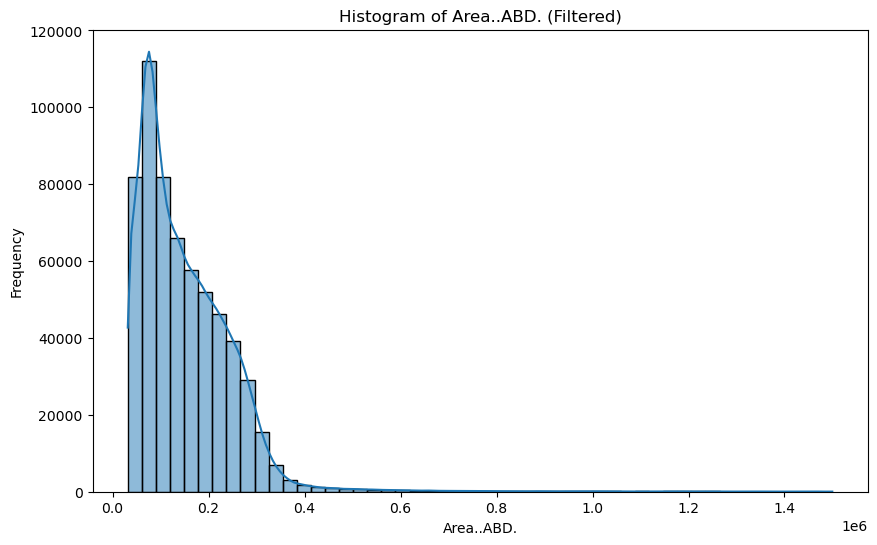

In [5]:
area_abd_summary = df['Area..ABD.'].describe()
print(area_abd_summary)

value = 1500000
quantile = (df["Area..ABD."] <= value).mean()

count_under_value = (df["Area..ABD."] > value).sum()
print(f"Number of entries under {value}: {count_under_value}")

print(f"The value {value} is at approximately the {quantile*100:.2f} percentile.")

# Exclude data where Area..ABD. is greater than the threshold value
area_filtered_df = df[df["Area..ABD."] <= value]

# Plot a histogram of Area..ABD.
plt.figure(figsize=(10, 6))
sns.histplot(area_filtered_df["Area..ABD."], bins=50, kde=True)
plt.title("Histogram of Area..ABD. (Filtered)")
plt.xlabel("Area..ABD.")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Assign "Others" to all plankton not in selected_classes
df[target_col] = df[target_col].apply(lambda x: x if x in selected_classes else "Others")

In [ ]:
[
    'Class.Particle.ID', 'Class', 'Area..ABD.', 'Area..Filled.', 'Aspect.Ratio',
    'Calibration.Factor', 'Calibration.Image', 'Camera', 'Capture.X', 'Capture.Y',
    'Circle.Fit', 'Circularity', 'Circularity..Hu.', 'Compactness', 'Convex.Perimeter',
    'Convexity', 'Date', 'Diameter..ABD.', 'Diameter..ESD.', 'Diameter..FD.',
    'Edge.Gradient', 'Elapsed.Time', 'Elongation', 'Feret.Angle.Max', 'Feret.Angle.Min',
    'Fiber.Curl', 'Fiber.Straightness', 'Filter.Score', 'Geodesic.Aspect.Ratio',
    'Geodesic.Length', 'Geodesic.Thickness', 'Image.File', 'Image.Height', 'Image.Width',
    'Image.X', 'Image.Y', 'Intensity', 'Length', 'Original.Reference.ID',
    'Particles.Per.Chain', 'Perimeter', 'Roughness', 'Sigma.Intensity', 'Source.Image',
    'Sphere.Complement', 'Sphere.Count', 'Sphere.Unknown', 'Sphere.Volume',
    'Sum.Intensity', 'Symmetry', 'Time', 'Timestamp', 'Transparency', 'Volume..ABD.',
    'Volume..ESD.', 'Width', 'Particle.ID', 'Source_File'
]

In [ ]:
class_proportions = df[target_col].value_counts(normalize=True)
print(class_proportions)

print("List of columns in the dataframe:")
print(df.columns.tolist())

In [ ]:
# Now let's exclude 'Others' too
df_no_others = df[(df[target_col] != 'TooSmall') & (df[target_col] != 'Others')]
# Sort by area and select top 10
top_area = df_no_others.sort_values(by='Area..ABD.', ascending=False).head(10)

# Columns needed for cropping the original image
cols_to_extract = ['Image.File', 'Class', 'Image.Height', 'Image.Width', 'Image.X', 'Image.Y', 'Source_File']
top_area_info = top_area[cols_to_extract]

# Show the info
print(top_area_info)


In [ ]:
# Now let's do EDA again without Others

area_volume_cols = ['Area..ABD.', 'Volume..ABD.', 'Sum.Intensity']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(area_volume_cols):
    sns.histplot(df_no_others[col], bins=30, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# histograms with y-limit
for i, col in enumerate(area_volume_cols):
    sns.histplot(df_no_others[col], bins=30, ax=axes[i + len(area_volume_cols)])
    axes[i + len(area_volume_cols)].set_title(f'Histogram of {col} with y-axis limit')
    axes[i + len(area_volume_cols)].set_xlabel(col)
    axes[i + len(area_volume_cols)].set_ylabel('Frequency')
    axes[i + len(area_volume_cols)].set_ylim(0, 100)

for j in range(2 * len(area_volume_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

First, we will do logistic regression. 
We need some assumptions for logistic regression. First is that features needed to be linearly separable. Since features of zooplankton data are not separable but we will use logistic regression as a baseline. As logistic regression is simple and interpretable, as well as handle imbalanced classes well, I choose logistic regression with a baseline. 
Second is that there should be no multicolinearity. To remove multicolinearity, we will use PCA as EDA. To know how many principal components to take, I investigated scree plot. Based on scree plot, I decided to take 7 principal components. 
Third is that features are on the same scale however we found that range is extremely large. Therefore we will do log transformation as well as standardize the features. 
We apply log transformation since a lot of features are highly right skewed. Standardization alone doesn't fix skewness but centers the data around 0 and scale variance, log transformation will help to handle highly skewed distribution. 
I tried two standardize methods, which are standard scaling and robust scaling. Instead of standardize with mean and standard deviation, RobustSclaer() will standardize with median and IQR. That means, instead of $\frac{X-E[X]}{\sigma}$, we will use $\frac{X-\text{median}}{IQR}$. However, due to the dominance of "Others" class and "Others" calss have wide range of every features since we treat all zooplankton except for selected classes as others, its variance may still be too compressed and gave poor accuracy. Therefore we'll use standard scaling. 

In [ ]:
X = df[feature_cols]
y = df[target_col]

# drop Feret.Angle.Max and Feret.Angle.Min since they have negative values
X_log = X.drop(columns=["Feret.Angle.Max", "Feret.Angle.Min"]).apply(lambda x: np.log1p(x))

# Standardize features
scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance ratio
explained_variance = pca_full.explained_variance_ratio_

# Plot Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=2453, stratify=y
)

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Since the accuracy is not as I want, I'll use XGBoost. 
Assumption: 
Reason:
When we do XGBoost, we'll train with selected classes and not with Others. Instead, we will classify a plankton with others when the prediction probability is less than threshold we set. 

In [ ]:
# # XGBoost Model with Hyperparameter Tuning
# param_dist = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0]
# }

# xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=2453)

# # Randomized Search for Hyperparameter Optimization
# random_search = RandomizedSearchCV(
#     xgb_clf, param_distributions=param_dist, 
#     n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# # Best model
# best_xgb = random_search.best_estimator_

# # Cross-validation to evaluate model
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
# scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="f1_weighted")
# print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# # Model evaluation using probability threshold
# y_prob = best_xgb.predict_proba(X_test)
# threshold = 0.7  # Define probability threshold
# max_probs = np.max(y_prob, axis=1)
# y_pred_indices = np.argmax(y_prob, axis=1)
# y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

# y_pred[max_probs < threshold] = "Others"

# print("Final Predictions:")
# print(y_pred)

# print("Classification Report:")
# print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))

In [ ]:
# # XGBoost Model with sample weights
# sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# xgb_clf = XGBClassifier(
#     eval_metric="mlogloss",
#     random_state=2453
# )

# # Randomized Search for Hyperparameter Optimization
# random_search = RandomizedSearchCV(
#     xgb_clf, param_distributions=param_dist, 
#     n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
# )

# random_search.fit(X_train, y_train, sample_weight = sample_weights)

# # Best model
# best_xgb = random_search.best_estimator_

# # Cross-validation to evaluate model
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
# scores = cross_val_score(best_xgb, X_train, y_train, cv=cv, scoring="f1_weighted")
# print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# # Model evaluation using probability threshold
# y_prob = best_xgb.predict_proba(X_test)
# threshold = 0.7  # Define probability threshold
# max_probs = np.max(y_prob, axis=1)
# y_pred_indices = np.argmax(y_prob, axis=1)
# y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

# y_pred[max_probs < threshold] = "Others"

# print("Final Predictions:")
# print(y_pred)

# print("Classification Report:")
# print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
# print("Confusion Matrix:")
# print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))

In [ ]:
# XGBoost Model with SMOTE
smote = SMOTE(random_state=2453)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost Model with Hyperparameter Tuning
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_clf = XGBClassifier(eval_metric="mlogloss", random_state=2453)

# Randomized Search for Hyperparameter Optimization
random_search = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist, 
    n_iter=20, scoring="f1_weighted", cv=5, verbose=1, n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_xgb = random_search.best_estimator_

# Cross-validation to evaluate model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2453)
scores = cross_val_score(best_xgb, X_train_resampled, y_train_resampled, cv=cv, scoring="f1_weighted")
print(f"Cross-validation F1-score: {np.mean(scores):.4f}")

# Model evaluation using probability threshold
y_prob = best_xgb.predict_proba(X_test)
threshold = 0.7  # Define probability threshold
max_probs = np.max(y_prob, axis=1)
y_pred_indices = np.argmax(y_prob, axis=1)
y_pred = label_encoder.inverse_transform(y_pred_indices)  # Convert back to class names

y_pred[max_probs < threshold] = "Others"

print("Final Predictions:")
print(y_pred)

print("Classification Report:")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred))
print("Confusion Matrix:")
print(confusion_matrix(label_encoder.inverse_transform(y_test), y_pred))